# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle Marty, Ghislain MUTABAZI, Nathan DAMBREVILLE

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import seaborn as sns

BASE_PATH = r"/home/ghislain/data_relou/"  #replace with base path to velo's data
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
LYON_CENTER = (45.764043, 4.835659)
unused_here_yet = """ 

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree
"""
print("✅ Libraries successfully imported")

✅ Libraries successfully imported


- *Useful Functions to compute the regression*

In [2]:
def my_train_test_split(X, Y, rate = 0.8):
    split_idx = int(len(X) * rate)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def build_coeffs_df(model):
    df_coeff = pd.DataFrame({
        'Coefficient': model.coef_
    }, index = X.columns)
    df_coeff.sort_values(by='Coefficient', ascending=False, inplace=True) 
    df_coeff = df_coeff.T
    df_coeff['intercept'] = model.intercept_
    df_coeff = df_coeff.T

    return df_coeff

def build_validation_serie(y_test, y_pred):
    s_validation = pd.Series({
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })
    return s_validation

## <u> I/ Data and libraries imports </u>

### a/ Data frame import function
Hereby `read_whole_pandas_df`

In [3]:
alt_path = '/home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

def read_whole_pandas_df(path, alternative_path=alt_path, sep = ",", enc = None, columns = None, parse_dates=None, format=None, alternative_dataset = False):
    if alternative_dataset:
        all_files = [alternative_path]
    else:
        all_files = glob.glob(path)
    li = []
    for filename in all_files:
        print("Reading file {}".format(filename))
        df = pd.read_csv(filename, encoding = enc, sep=sep, names = columns, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

### b/ Data import
In the variable `df_lyon`

In [4]:

df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=True)

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")

print(" Size of the dataframe:", df_lyon.shape)
df_lyon.head()

Reading file /home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
 Size of the dataframe: (2142472, 6)


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00


##  <u> II - Filtering & adding the travel time   </u>

### a/ Adding the `travel_time` column

**NB:** It is the variable we're trying to predict (in minutes)

In [5]:
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,28.0
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,7.0
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,7.0
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,14.0
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,4.0


### b/  Filtering by speeds
We will only keep trips with a reasonnable overall speed, so ranging from 5 km/h to 16 km/h

#### *i ⋅ Creating a `distance` column*

In [6]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]

#Clean up
del df_dist, dist_matrix, coords, row_idx, col_idx

df_lyon.head()

idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271302,2101.306114,1728.531157,2359.789599,1897.619994,2771.548414,1581.022501,1739.714331,...,1487.311727,2209.079368,8316.839400,7914.027094,1190.596430,1448.733488,1397.488836,1707.214748,4936.861622,5241.842046
10063,3672.322221,0.000000,367.937590,1918.014220,5276.485491,2393.483029,3362.975962,2193.760999,4699.773040,5159.729410,...,2185.076727,2763.907649,6395.079493,4458.602747,4860.315823,2233.220172,4667.580450,2109.599781,1478.056507,2520.604550
10021,4038.271302,367.937590,0.000000,2269.206815,5644.183932,2665.024203,3700.574286,2477.416756,5062.122623,5525.999425,...,2550.967782,3042.980467,6250.871362,4115.750369,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306114,1918.014220,2269.206815,0.000000,3484.503141,2327.918949,1467.055845,883.373262,2817.475108,3322.282655,...,940.820391,2518.623358,7840.242908,6376.168575,3252.453650,1066.873700,2814.886550,1368.271052,3379.142600,4169.994273
7045,1728.531157,5276.485491,5644.183932,3484.503141,0.000000,4061.439766,2522.986996,3875.840708,919.283986,340.362043,...,3133.747733,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331062


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time,distance
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,28.0,4659.845582
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,7.0,1629.727220
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,7.0,1610.518885
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,14.0,3446.325686
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,4.0,807.072642


#### *ii ⋅ Filtering by speed*

In [7]:
# As we cannot say anything about trips starting and ending at the same station, we will remove them
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

shape_before = df_lyon.shape
# We will only keep trips with a reasonnable overall speed, so ranging from 5 km/h to 16 km/h
# 5 km/h = 5000 m / 60 min = 83.33 m/min
# 16 km/h = 16000 m / 60 min = 266.67 m/min
df_lyon = df_lyon[df_lyon.distance/df_lyon.travel_time>=83.33]
df_lyon = df_lyon[df_lyon.distance/df_lyon.travel_time<=266.67]

print(f"Filtered out {shape_before[0]-df_lyon.shape[0]} rows based on speed criteria.")
print(" In percentage:", round(100*(shape_before[0]-df_lyon.shape[0])/shape_before[0],2), "%")

#Clean up
del shape_before
df_lyon.dropna(inplace=True)
df_lyon.sample(10)

Filtered out 194280 rows based on speed criteria.
 In percentage: 9.72 %


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time,distance
1635628,2001,2001 - BELLECOUR / RÉPUBLIQUE,2019-06-06 11:08:00+02:00,8009.0,8009 - JEAN XXIII / MERMOZ,2019-06-06 11:39:00+02:00,31.0,3632.937511
2074104,7003,7003 - GAMBETTA / GARIBALDI,2019-06-27 08:27:00+02:00,6028.0,6028 - RÉCAMIER / TÊTE D'OR,2019-06-27 08:39:00+02:00,12.0,1394.667655
1844802,10038,10038 - CONDORCET,2019-06-17 12:03:00+02:00,3015.0,3015 - SERVIENT / GARIBALDI,2019-06-17 12:24:00+02:00,21.0,2307.370998
1825850,10006,10006 - CHARPENNES,2019-06-16 13:09:00+02:00,6044.0,6044 - CHARMETTES / BELLECOMBE,2019-06-16 13:12:00+02:00,3.0,453.647449
367512,4024,4024 - LYON METROPOLE,2019-04-14 16:07:00+02:00,9014.0,9014 - QUAI DU COMMERCE,2019-04-14 16:14:00+02:00,7.0,918.290910
931917,2041,2041 - SALA / CHARITÉ,2019-05-09 13:54:00+02:00,1032.0,1032 - PIZAY,2019-05-09 14:00:00+02:00,6.0,1437.579270
659838,5006,5006 - QUAI ROMAIN ROLLAND,2019-04-28 05:29:00+02:00,2042.0,2042 - JOFFRE / VAUBECOUR,2019-04-28 05:39:00+02:00,10.0,1173.977684
2087874,7041,7041 - DOMER / CHEVREUL,2019-06-27 19:18:00+02:00,7018.0,7018 - LYCEE LOUISE LABE,2019-06-27 19:24:00+02:00,6.0,1196.414226
1183602,7035,7035 - MARSEILLE / UNIVERSITÉ,2019-05-20 03:56:00+02:00,2039.0,2039 - CHARITÉ / RÉCAMIER,2019-05-20 04:00:00+02:00,4.0,756.562255
15769,7024,7024 - BANCEL / CHEVREUL,2019-04-01 16:06:00+02:00,6001.0,6001 - GARE DES BROTTEAUX,2019-04-01 16:25:00+02:00,19.0,2496.232987


Clean up of this first part

In [8]:
# del unused_here_yet, BASE_PATH, LYON_PATH, LYON_LOCATIONS, LYON_CENTER
del read_whole_pandas_df, alt_path
df_lyon.dropna(inplace=True)
print("✅ Clean up done")

✅ Clean up done


###  <u> **1 - Model 0 // Simple linear regression** </u>
#### a/ Model definition

In [9]:
# STEP 1 - GIVE IT A NAME

y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - GIVE IT A NAME

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - GIVE IT A NAME AND COMMENT ON EACH LINE

model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

print(model.intercept_, model.coef_, )

# STEP 4 - GIVE IT A NAME
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

0.9679168945145502 [0.0057767]


R²      0.776031
MSE    10.410655
MAE     2.237617
dtype: float64

In [10]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 10min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

###  <u> **1 - Model 1 // Multiple linear regression** </u>
#### a/ Adding the day of the week parameter

In [ ]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day', 'month']].copy()
df_model1.sample(5)

KeyError: "['datetime_1h', 'day', 'month'] not in index"

In [32]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

,distance,travel_time,datetime_1h,month,day_1,day_2,day_3,day_4,day_5,day_6
1853779,766.025237,4.0,2019-06-17 18:00:00+02:00,6,0,0,0,0,0,0
170259,1584.393560,9.0,2019-04-07 14:00:00+02:00,4,0,0,0,0,0,1
687695,2422.922403,18.0,2019-04-29 18:00:00+02:00,4,0,0,0,0,0,0
1300689,1119.703494,13.0,2019-05-24 04:00:00+02:00,5,0,0,0,1,0,0
1661353,1178.341104,7.0,2019-06-07 08:00:00+02:00,6,0,0,0,1,0,0


,Coefficient
day_5,1.027371
day_6,0.886977
day_2,0.285906
day_4,0.283732
day_3,0.112139
day_1,0.056494
distance,0.004896
intercept,2.435412


R²      0.615426
MSE    14.318934
MAE     2.623344
dtype: float64

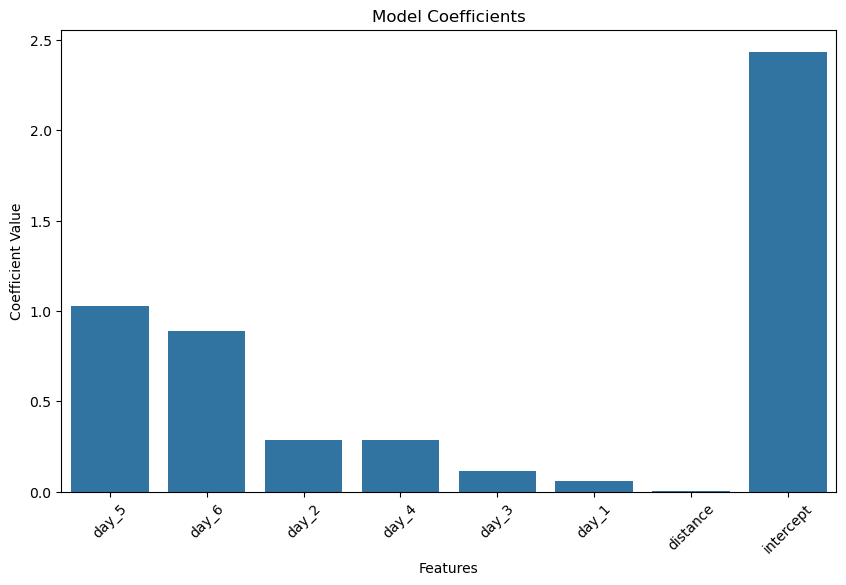

In [33]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['month', 'datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Adding the time of day parameter

In [ ]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies_hour = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies_hour.sample(5)

,distance,travel_time,datetime_1h,month,day_1,day_2,day_3,day_4,day_5,day_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
1265468,900.682137,5.0,2019-05-22 22:00:00+02:00,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
337918,1432.448148,8.0,2019-04-13 09:00:00+02:00,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
167025,1168.058147,6.0,2019-04-07 11:00:00+02:00,4,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
344092,1575.315469,13.0,2019-04-13 14:00:00+02:00,4,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
383005,1391.455729,9.0,2019-04-15 12:00:00+02:00,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


: 

In [ ]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies_hour['travel_time']
X = df_model1_dummies_hour.drop(columns=['month', 'datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('green')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

###  <u> **2 - Model 2 // Finding clusters affecting þe travel time** </u>

#### **a/ Defining clusters by proximity to important places**

##### i ⋅ Station dataframe `gdf_stations`

- Some information about it 

In [12]:
# Loading station coordinates
gdf_stations = gpd.read_file(BASE_PATH + 'VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json')
gdf_stations.to_crs(epsg=4326, inplace=True)

print("Columns : ",  list(gdf_stations.columns) )
print("Shape of gdf_stations:", gdf_stations.shape)
print("Number of unique stations:", gdf_stations['idstation'].nunique())

Columns :  ['idstation', 'nom', 'adresse1', 'adresse2', 'commune', 'numdansarrondissement', 'nbbornettes', 'stationbonus', 'pole', 'ouverte', 'achevement', 'gid', 'code_insee', 'geometry']
Shape of gdf_stations: (431, 14)
Number of unique stations: 431


- **Extracting** þe useful columns in `gdf_useful`

In [13]:
# Extracting the longitude & latitude of stations
gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
gdf_stations['latitude'] = gdf_stations.geometry.centroid.y

gdf_useful = gdf_stations[['idstation', 'longitude', 'latitude']]

# Memory cleanup
del gdf_stations

print(gdf_useful.head())

   idstation  longitude   latitude
0       7024   4.840525  45.748520
1      10063   4.885609  45.758392
2      10021   4.889947  45.759718
3       8038   4.867429  45.746716
4       7045   4.824488  45.737741


/tmp/ipykernel_6969/2871351467.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
/tmp/ipykernel_6969/2871351467.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['latitude'] = gdf_stations.geometry.centroid.y


##### ii ⋅ Definition and implementation of clusters

In [14]:
# Define the coordinates of each cluster center
clusters_centers = {
    'LA_DOUA': (45.783479, 4.875842),
    'TETE_D_OR': (45.778341, 4.853017),
    'LA_PART_DIEU': (45.761882, 4.855204),
    'OLD_TOWN': (45.764043, 4.835659),
    'CONFLUENCE': (45.732634, 4.819839),
    'FOURVIERE': (45.762455, 4.821639),
    'CROIX_ROUSSE': (45.775873,4.830042 )
}

# Define the radius of influence for each cluster in METERS
clusters_radius = {
    'LA_DOUA': 1000,
    'TETE_D_OR': 900,
    'LA_PART_DIEU': 500,
    'OLD_TOWN': 500,
    'CONFLUENCE': 1000,
    'FOURVIERE': 700,
    'CROIX_ROUSSE': 500
}

# Define the color in which the cluster shall appear on the map
color_map = {
    'LA_DOUA': 'red',
    "TETE_D_OR": 'green',
    'LA_PART_DIEU': 'orange',
    'OLD_TOWN': 'purple',
    'CONFLUENCE': 'cyan',
    'FOURVIERE': 'magenta',
    'CROIX_ROUSSE': 'brown',
    'NO_CLUSTER': 'gray'
}


Þe distance function

In [15]:
# Function to calculate distance between two geographic points in METERS
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 1000  # Return distance in METERS

- **Assigning** each station to a cluster by **adding new `bool` type columns** in `gdf_useful`

In [16]:
for name, (lat_c, lon_c) in clusters_centers.items():
    distances = haversine(
        gdf_useful['longitude'], gdf_useful['latitude'],
        lon_c, lat_c
    )
    gdf_useful[name] = (distances < clusters_radius[name]).astype(int)

# Creating a column indicating if a station does not belong to any cluster
gdf_useful['NO_CLUSTER'] = (gdf_useful[list(clusters_centers.keys())].sum(axis=1) == 0).astype(int)

# Cleanup
del distances
gdf_useful.head(10)

,idstation,longitude,latitude,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER
0,7024,4.840525,45.748520,0,0,0,0,0,0,0,1
1,10063,4.885609,45.758392,0,0,0,0,0,0,0,1
2,10021,4.889947,45.759718,0,0,0,0,0,0,0,1
3,8038,4.867429,45.746716,0,0,0,0,0,0,0,1
4,7045,4.824488,45.737741,0,0,0,0,1,0,0,0
5,6045,4.857002,45.766367,0,0,0,0,0,0,0,1
6,8056,4.856813,45.735795,0,0,0,0,0,0,0,1
7,8015,4.874194,45.740326,0,0,0,0,0,0,0,1
8,7057,4.835497,45.734725,0,0,0,0,0,0,0,1
9,7007,4.827719,45.735674,0,0,0,0,1,0,0,0


##### iii ⋅ Checks to see if the clusters are realistic

- **Checking** if þere is a reasonable **amount of station per cluster**

In [17]:
print("Number of stations in")
for cluster in clusters_centers.keys():
    print(f"{cluster} :", gdf_useful[cluster].sum(), ", soit ", round(gdf_useful[cluster].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

# Nombre de stations non assignées à un cluster
print("NO_CLUSTER :", gdf_useful['NO_CLUSTER'].sum(), ", soit ", round(gdf_useful['NO_CLUSTER'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

Number of stations in
LA_DOUA : 14 , soit  3.25 %
TETE_D_OR : 18 , soit  4.18 %
LA_PART_DIEU : 10 , soit  2.32 %
OLD_TOWN : 18 , soit  4.18 %
CONFLUENCE : 11 , soit  2.55 %
FOURVIERE : 10 , soit  2.32 %
CROIX_ROUSSE : 9 , soit  2.09 %
NO_CLUSTER : 341 , soit  79.12 %


- Hereafter define we the centers of inertia (centroids) of each area of interest in `clusters_centroids` dictionnary (useful for þe next model)

In [18]:
clusters_centroids = {}

# Number of significant digits for centroid coordinate calculations
n_ = 5 # +1 !

for cluster in clusters_centers.keys():
    # Filter stations close to the location (value = 1)
    subset = gdf_useful[gdf_useful[cluster] == 1]

    # Calculate the mean coordinates
    mean_lat = subset['latitude'].mean()
    mean_lon = subset['longitude'].mean()

    # Store the rounded centroid in the dictionary
    clusters_centroids[cluster] = (round(mean_lat, ndigits=n_), round(mean_lon, ndigits=n_))

# Cleanup
del mean_lat, mean_lon, subset, n_

clusters_centroids


{'LA_DOUA': (np.float64(45.77999), np.float64(4.87625)),
 'TETE_D_OR': (np.float64(45.77873), np.float64(4.85469)),
 'LA_PART_DIEU': (np.float64(45.76175), np.float64(4.85389)),
 'OLD_TOWN': (np.float64(45.76428), np.float64(4.83519)),
 'CONFLUENCE': (np.float64(45.7335), np.float64(4.82187)),
 'FOURVIERE': (np.float64(45.76346), np.float64(4.82552)),
 'CROIX_ROUSSE': (np.float64(45.77595), np.float64(4.83006))}

**Visual check of þe clusters**

- Set `all_stations` to `True` if you wish to display þe **stations outside of clusters** as well
- You can also change þe colours of þe clusters 

In [19]:
##### Modifiable parameters for the visualization of þe clusters ####
#####################################################################

all_stations = False
# Size of the points representing þe clustered stations 
size1 = 15

# Size of þe stations outside of clusters
size0 = 10

/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6969/3728467301.py:62: UserWarning: Setting the '

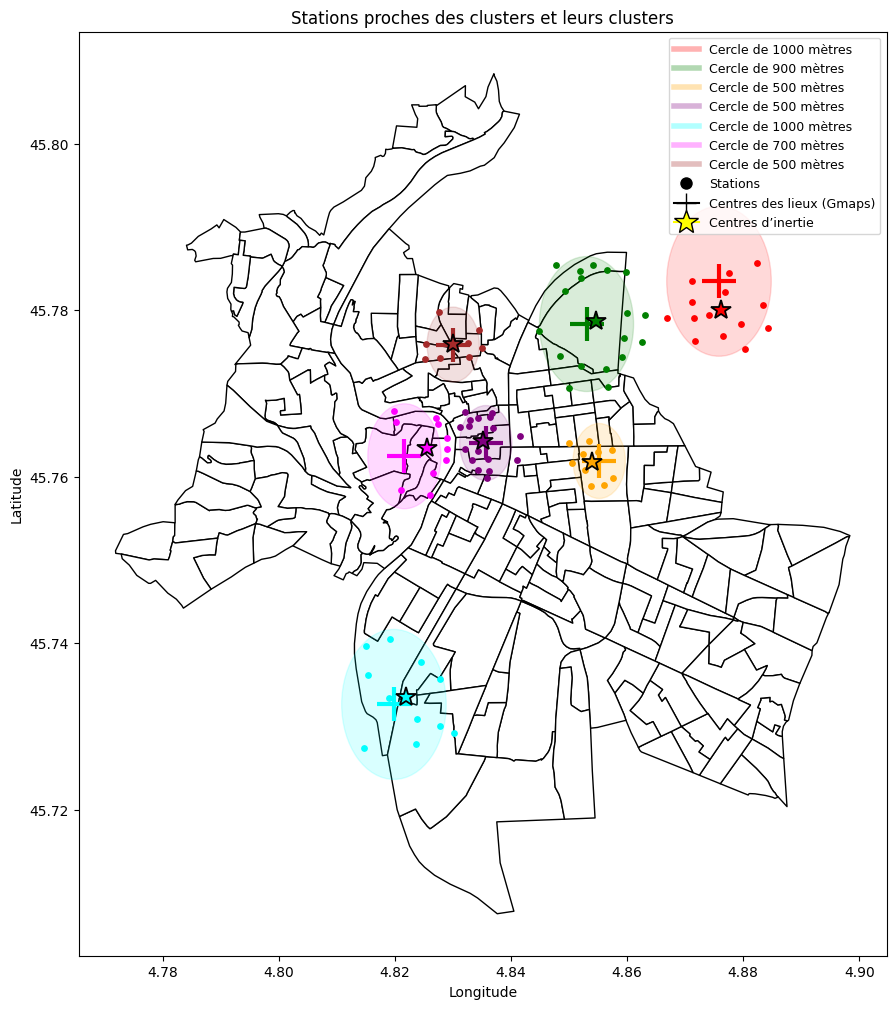

✅ Map with points, centroids, and centers successfully plotted.


In [20]:
# Loading þe shapefile
gdf = gpd.read_file(LYON_IRIS)
gdf.to_crs(epsg=4326, inplace=True)

# Converting gdf_useful in GeoDataFrame of points
gdf_points = gpd.GeoDataFrame(
    gdf_useful,
    geometry=gpd.points_from_xy(gdf_useful.longitude, gdf_useful.latitude),
    crs="EPSG:4326"  # car mes coordonnées sont en lat/lon
)

fig, ax = plt.subplots(figsize=(12, 12))

# Map background
gdf.plot(ax=ax, facecolor="white", edgecolor="black")

legend_handles = []  # to create a proper legend

for place, (lat_c, lon_c) in clusters_centers.items():

    tol    = clusters_radius[place]  # Tolérance en mètres
    color0 = color_map[place]

    # -----------------------------
    # 1/6 Stations proches (points)
    # -----------------------------
    pts = gdf_points[gdf_points[place] == 1].plot(
        ax         = ax,
        color      = color0,
        markersize = size1
    )
    
    # -----------------------------
    # 2/6 Centre exact du lieu (+)
    # -----------------------------
    ax.plot(
        lon_c, lat_c,
        marker     = "+",
        markersize = 25,
        color      = color0,
        mew        = 3
    )

    # -----------------------------
    # 3/6 Centre d’inertie (étoile)
    # -----------------------------
    lat_mean, lon_mean = clusters_centroids[place]
    ax.plot(
        lon_mean, lat_mean,
        marker     = "*",
        markersize = 15,
        color      = color0,
        markeredgecolor = "black",
        markeredgewidth=1.3
    )

    # -----------------------------
    # 4/6 Cercle (buffer de 1 km)
    # -----------------------------
    # Conversion approx. km → degrés (1° lat ≈ 111 km)
    km_to_deg = tol / (111 * 1000)
    circle = plt.Circle(
        (lon_c, lat_c),
        km_to_deg,
        color=color0,
        alpha=0.15,
        edgecolor=color0
    )
    ax.add_patch(circle)

    legend_handles.append(
        plt.Line2D([0], [0], color=color0, lw=4, alpha=0.3,
                    label=f"Cercle de {tol} mètres")
    )


# -----------------------------
# 5/6 Stations en dehors des clusters (points)
# -----------------------------
if all_stations:
    color0 = color_map['NO_CLUSTER']
    pts = gdf_points[gdf_points['NO_CLUSTER'] == 1].plot(
    ax         = ax,
    color      = color0,
    markersize = size0
    )

# -----------------------------
# 6/6 Éléments pour la légende
# -----------------------------
legend_handles.append(
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black',
                label=f"Stations", markersize=10)
)
legend_handles.append(
    plt.Line2D([0], [0], marker='+', color='black', markersize=15,
                label=f"Centres des lieux (Gmaps)")
)
legend_handles.append(
    plt.Line2D([0], [0], marker='*', color='yellow', markeredgecolor='black',
                markersize=18, label=f"Centres d’inertie")
)
    
# --- Mise en forme finale ---
plt.title(f"Stations proches des clusters et leurs clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=legend_handles, loc='upper right', fontsize=9)
plt.grid(False)

plt.show()
print("✅ Map with points, centroids, and centers successfully plotted.")

#### **b/ First Multi Linear regression**

##### i ⋅ Adding the clusters columns in the main dataset

- **Adding a cluster name column in `gdf_useful`**

In [21]:
# Number of clusters (based on the length of the cluster centers list)
n_clusters = len(clusters_centers)

# Identify the cluster columns (all columns except the first 3)
# Assuming the actual cluster columns start at index 2 and run for n_clusters columns.
cluster_cols = gdf_useful.columns[3:3+n_clusters+1]

# Create the 'cluster' column by finding the column name that has the value 1 (the one-hot encoded cluster assignment)
gdf_useful['cluster'] = gdf_useful[cluster_cols].idxmax(axis=1)

# The DataFrame gdf_useful now has a 'cluster' column with the assigned cluster name
gdf_useful.head(10)

,idstation,longitude,latitude,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER,cluster
0,7024,4.840525,45.748520,0,0,0,0,0,0,0,1,NO_CLUSTER
1,10063,4.885609,45.758392,0,0,0,0,0,0,0,1,NO_CLUSTER
2,10021,4.889947,45.759718,0,0,0,0,0,0,0,1,NO_CLUSTER
3,8038,4.867429,45.746716,0,0,0,0,0,0,0,1,NO_CLUSTER
4,7045,4.824488,45.737741,0,0,0,0,1,0,0,0,CONFLUENCE
5,6045,4.857002,45.766367,0,0,0,0,0,0,0,1,NO_CLUSTER
6,8056,4.856813,45.735795,0,0,0,0,0,0,0,1,NO_CLUSTER
7,8015,4.874194,45.740326,0,0,0,0,0,0,0,1,NO_CLUSTER
8,7057,4.835497,45.734725,0,0,0,0,0,0,0,1,NO_CLUSTER
9,7007,4.827719,45.735674,0,0,0,0,1,0,0,0,CONFLUENCE


- **Adding the cluster name column in `gdf_useful`**

In [22]:
# Join df_lyon (the main data frame) with the cluster mapping
df_model2 = df_lyon.merge(
    gdf_useful.drop(columns=['longitude','latitude'], inplace=False).rename(columns={'idstation': 'id_return_station', 'cluster': 'return_cluster'}),
    on='id_return_station',
    how='left'  # Use a left join to keep all rows from the main data frame (df_lyon)
)

df_model2.head(10)

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time,distance,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER,return_cluster
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,28.0,4659.845582,0,0,0,0,0,0,0,1,NO_CLUSTER
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,7.0,1629.727220,0,1,0,0,0,0,0,0,TETE_D_OR
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,7.0,1610.518885,0,0,0,1,0,0,0,0,OLD_TOWN
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,14.0,3446.325686,0,0,0,0,0,0,0,1,NO_CLUSTER
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,4.0,807.072642,0,0,0,0,0,0,0,1,NO_CLUSTER
5,10027,10027 - MAIRIE DE VILLEURBANNE,2019-04-01 00:01:00+02:00,2042.0,2042 - JOFFRE / VAUBECOUR,2019-04-01 00:29:00+02:00,28.0,4612.882941,0,0,0,0,0,0,0,1,NO_CLUSTER
6,2020,2020 - MUSÉE DES CONFLUENCES,2019-04-01 00:02:00+02:00,2003.0,2003 - PLACE AMPÈRE,2019-04-01 00:13:00+02:00,11.0,2300.865255,0,0,0,0,0,0,0,1,NO_CLUSTER
7,2020,2020 - MUSÉE DES CONFLUENCES,2019-04-01 00:02:00+02:00,2003.0,2003 - PLACE AMPÈRE,2019-04-01 00:13:00+02:00,11.0,2300.865255,0,0,0,0,0,0,0,1,NO_CLUSTER
8,10056,10056 - 11 NOVEMBRE / GASTON BERGER,2019-04-01 00:02:00+02:00,10028.0,10028 - ECOLE DE MUSIQUE,2019-04-01 00:09:00+02:00,7.0,1297.058526,0,0,0,0,0,0,0,1,NO_CLUSTER
9,2002,2002 - BELLECOUR / ST EXUPÉRY,2019-04-01 00:02:00+02:00,7004.0,7004 - MAIRIE DU 7E,2019-04-01 00:12:00+02:00,10.0,1585.967580,0,0,0,0,0,0,0,1,NO_CLUSTER


- Adding an exit_cluster column then **actually filtering** lines with identincal exit_clust & return_cluster

In [23]:
# Preparing the merge
cluster_mapping_exit = gdf_useful[['idstation', 'cluster']].rename(
    columns={'idstation': 'id_exit_station', 'cluster': 'exit_cluster'}
)

# Merging to easily acces the cluster of the exit station
df_model2 = df_model2.merge(
    cluster_mapping_exit,
    on='id_exit_station',
    how='left'
)
size0, ratio = df_model2.shape[0], 0

# Creating a filter (boolean series) which is True if clusters are different
# !! It's remove all trips outside of clusters !!
condition_different_clusters = (df_model2['exit_cluster'] != df_model2['return_cluster'])

# Applying the filter
df_model2 = df_model2[condition_different_clusters].copy()

# Information on lost trips
print("Number of trip lost : ", size0 - df_model2.shape[0], ", roughly ", 100*(1 - round(df_model2.shape[0]/size0, 2)), "%" )


# Unused columns
df_model2 = df_model2.drop(columns=['exit_cluster', 'return_cluster'])

# Memory cleanup
del cluster_mapping_exit, condition_different_clusters

Number of trip lost :  1008250 , roughly  56.00000000000001 %


##### ii ⋅ Computing the regression

Model 2 completed !


,Coefficient
CONFLUENCE,4.520419
TETE_D_OR,1.496928
LA_DOUA,0.393208
NO_CLUSTER,0.027353
OLD_TOWN,-0.583727
FOURVIERE,-0.655588
LA_PART_DIEU,-2.030784
CROIX_ROUSSE,-3.167808
intercept,12.484805


Validation of Model 2


R²      0.032720
MSE    46.279222
MAE     5.216061
dtype: float64

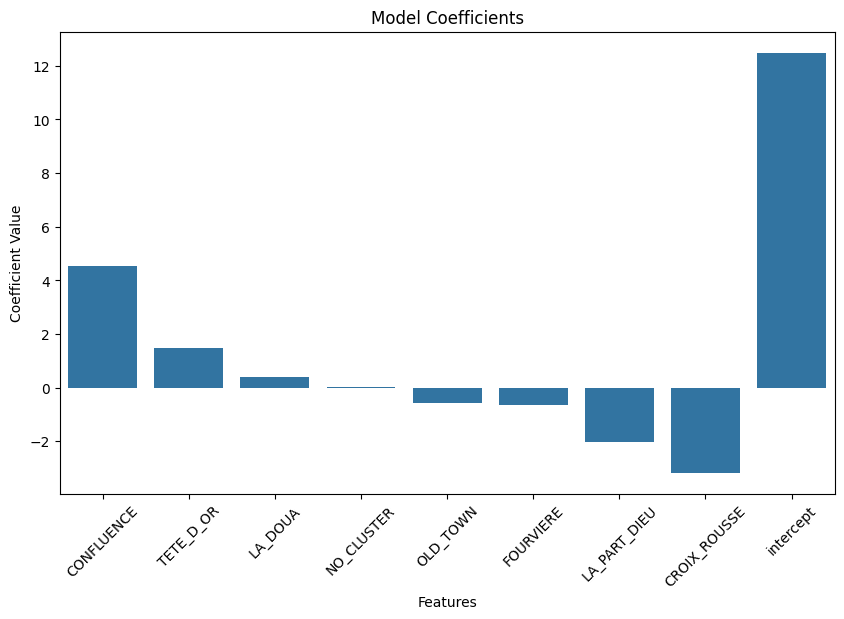

In [24]:
# Creating our multi-linear regression model, predicting the travel time based on the cluster of the return station !

## Splitting our data using my_train_test_split function
y = df_model2['travel_time']

non_x = ['id_exit_station',	'exit_station',	'date_exit', 'id_return_station', 'return_station', 'date_return', 'travel_time', 'distance']
X = df_model2.drop(columns=non_x)
del non_x

X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating model 2
model2 = LinearRegression()
model2.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2)

print("Model 2 completed !")
display(df_model2_coeffs)

## Displaying model 2's validation serie
y_pred_model2 = model2.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)

print("Validation of Model 2")
display(s_model2_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()